In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

In [108]:
train = pd.read_csv('data/train.csv')

In [109]:
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [110]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


In [111]:
train.isna().sum() / len(train) * 100

id                      0.000000
Brand                   3.235000
Material                2.782333
Size                    2.198333
Compartments            0.000000
Laptop Compartment      2.481333
Waterproof              2.350000
Style                   2.656667
Color                   3.316667
Weight Capacity (kg)    0.046000
Price                   0.000000
dtype: float64

In [112]:
[(i, train[i].unique()) if train[i].nunique() <= 10 else (i, train[i].nunique()) for i in train.columns]

[('id', 300000),
 ('Brand',
  array(['Jansport', 'Under Armour', 'Nike', 'Adidas', 'Puma', nan],
        dtype=object)),
 ('Material',
  array(['Leather', 'Canvas', 'Nylon', nan, 'Polyester'], dtype=object)),
 ('Size', array(['Medium', 'Small', 'Large', nan], dtype=object)),
 ('Compartments', array([ 7., 10.,  2.,  8.,  1.,  3.,  5.,  9.,  6.,  4.])),
 ('Laptop Compartment', array(['Yes', 'No', nan], dtype=object)),
 ('Waterproof', array(['No', 'Yes', nan], dtype=object)),
 ('Style', array(['Tote', 'Messenger', nan, 'Backpack'], dtype=object)),
 ('Color',
  array(['Black', 'Green', 'Red', 'Blue', 'Gray', 'Pink', nan], dtype=object)),
 ('Weight Capacity (kg)', 181596),
 ('Price', 48212)]

<Axes: xlabel='Price', ylabel='Count'>

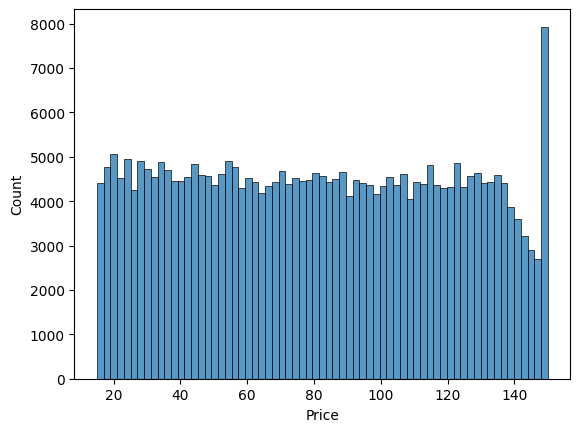

In [113]:
sns.histplot(train.Price)

In [114]:
train.Price.value_counts()

Price
150.00000    5528
15.00000      693
23.59584       22
17.31514       21
62.36063       21
             ... 
82.31121        1
90.79389        1
111.37389       1
94.99611        1
41.96325        1
Name: count, Length: 48212, dtype: int64

In [115]:
train = train[train.Price < 150]

In [116]:
# [train[i].mode() for i in train.columns.drop('id')]

In [117]:
X_train = train.drop('Price', axis=1)
y_train = train.Price

<Axes: ylabel='Frequency'>

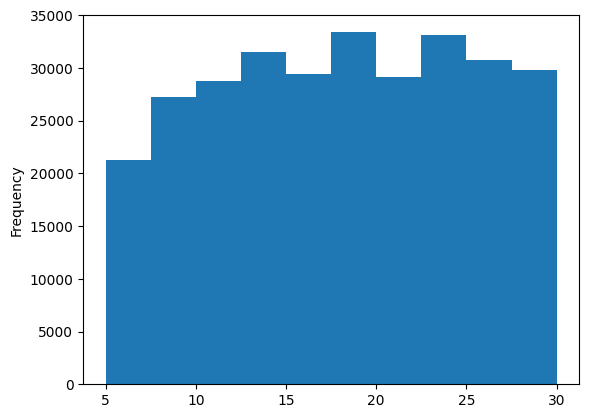

In [118]:
X_train['Weight Capacity (kg)'].plot(kind='hist')

In [119]:
X_train.columns

Index(['id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)'],
      dtype='object')

In [ ]:
class modifyColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = X.copy()

        X_new['WeightCat'] = pd.cut(X_new['Weight Capacity (kg)'], bins=3, labels=['Light', 'Medium', 'Heavy'])
        X_new.drop(['id'], axis=1, inplace=True)
        
        return X_new

In [121]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [122]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  
])

In [123]:
numerical_cols = ['Compartments', 'Weight Capacity (kg)']  
categorical_cols = ['Brand', 'Material', 'Size', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'WeightCat']

In [124]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols), 
        ('cat', categorical_transformer, categorical_cols)  
    ]
)

In [125]:
pipeline = Pipeline([
    ('modifyColumns', modifyColumns()),
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [126]:
modifyColumns().transform(X_train)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),WeightCat
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,Light
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,Heavy
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,Medium
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,Light
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,Medium
...,...,...,...,...,...,...,...,...,...,...
299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,Light
299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,Heavy
299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,Light
299998,Adidas,Nylon,Small,1.0,No,Yes,Tote,Pink,6.175738,Light


In [127]:
param_grid = {
    'regressor': [CatBoostRegressor()],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)


Learning rate set to 0.100528
0:	learn: 38.2418278	total: 153ms	remaining: 2m 32s
1:	learn: 38.2379211	total: 173ms	remaining: 1m 26s
2:	learn: 38.2354683	total: 192ms	remaining: 1m 3s
3:	learn: 38.2327992	total: 213ms	remaining: 52.9s
4:	learn: 38.2304042	total: 235ms	remaining: 46.8s
5:	learn: 38.2287051	total: 255ms	remaining: 42.3s
6:	learn: 38.2268232	total: 282ms	remaining: 40s
7:	learn: 38.2251950	total: 315ms	remaining: 39s
8:	learn: 38.2233925	total: 334ms	remaining: 36.8s
9:	learn: 38.2216207	total: 352ms	remaining: 34.9s
10:	learn: 38.2199168	total: 375ms	remaining: 33.7s
11:	learn: 38.2189637	total: 394ms	remaining: 32.5s
12:	learn: 38.2175043	total: 413ms	remaining: 31.3s
13:	learn: 38.2166414	total: 432ms	remaining: 30.5s
14:	learn: 38.2157654	total: 466ms	remaining: 30.6s
15:	learn: 38.2146771	total: 485ms	remaining: 29.8s
16:	learn: 38.2139582	total: 506ms	remaining: 29.2s
17:	learn: 38.2128352	total: 526ms	remaining: 28.7s
18:	learn: 38.2118852	total: 557ms	remaining: 

In [128]:
test = pd.read_csv('data/test.csv')

In [129]:
test.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
1,300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
2,300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
3,300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
4,300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [130]:
best_model = grid_search.best_estimator_

y_test = best_model.predict(test)

print("Predictions: ", y_test)

Predictions:  [77.58484642 69.3531298  95.26676658 ... 81.85949314 76.66403836
 81.31065263]


In [131]:
result = pd.DataFrame(y_test, columns=['Price'])

In [132]:
test.join(result)[['id', 'Price']].to_csv('submission.csv', index=False)